In [1]:
import pandas as pd
from textblob import TextBlob
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from tqdm import tqdm

#define RMSE
# l1-true,l2-false
def RMSE(l1, l2):
    length = len(l1)
    sum = 0
    for i in range(length):
        sum = sum + np.square(l1[i] - l2[i])
    return math.sqrt(sum / length)


#define MAE
def MAE(l1, l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    mae = sum(np.abs(l1 - l2)) / n
    return mae


#def MAPE
def MAPE(l1, l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    for i in range(len(l1)):
        if l1[i] == 0:
            l1[i] = 0.01
    mape = sum(np.abs((l1 - l2) / l1)) / n
    return mape

# new model for each time
def get_model():
    return AdaBoostRegressor(base_estimator=DecisionTreeRegressor(
        splitter="random", max_depth=1, min_samples_split=3),
                            n_estimators=30,
                            learning_rate=0.01)



df_integrated_series = pd.read_csv("integrated_series.csv")
df_integrated_series.date = pd.to_datetime(
    df_integrated_series.date)


In [5]:
lag_dict = {'topic1':7,'topic2':7,'topic3':7,'topic4':7,'normalized_polarity': 7, 'normalized_price': 2}


frame = []
series_index = 1
for each_type in lag_dict:
    lag = lag_dict[each_type]
    ts = df_integrated_series[each_type].tolist()
    df = pd.DataFrame(ts)
    n_vars = 1 if type(ts) is list else ts.shape[1]
    cols, names = list(), list()
    # input sq(t-n,...,t-1)
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('(t-%d)%d' % (i, j + 1)) for j in range(n_vars)]
    # forecast sq(t,t+1,..,t+n)
    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('(t)%d' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('(t+%d)' % (j + 1)) for j in range(n_vars)]
    # put it all together
    df_shifted_series = pd.concat(cols, axis=1)
    df_shifted_series.columns = names
    # drop rows with NaN values
    df_shifted_series.dropna(inplace=True)
    colList = df_shifted_series.columns
    length = len(colList)
    df_shifted_series.columns = [
        'var' + str(series_index) + '(t-%d)' % (length - 1 - i)
        for i in range(length)
    ]
    series_index += 1
    frame.append(df_shifted_series)

df_all_shifted_series = pd.concat(frame, axis=1)
df_all_shifted_series.dropna(inplace=True)


In [7]:
df_all_shifted_series.columns

Index(['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)',
       'var1(t-2)', 'var1(t-1)', 'var1(t-0)', 'var2(t-7)', 'var2(t-6)',
       'var2(t-5)', 'var2(t-4)', 'var2(t-3)', 'var2(t-2)', 'var2(t-1)',
       'var2(t-0)', 'var3(t-7)', 'var3(t-6)', 'var3(t-5)', 'var3(t-4)',
       'var3(t-3)', 'var3(t-2)', 'var3(t-1)', 'var3(t-0)', 'var4(t-7)',
       'var4(t-6)', 'var4(t-5)', 'var4(t-4)', 'var4(t-3)', 'var4(t-2)',
       'var4(t-1)', 'var4(t-0)', 'var5(t-7)', 'var5(t-6)', 'var5(t-5)',
       'var5(t-4)', 'var5(t-3)', 'var5(t-2)', 'var5(t-1)', 'var5(t-0)',
       'var6(t-2)', 'var6(t-1)', 'var6(t-0)'],
      dtype='object')

In [8]:

for name in df_all_shifted_series.columns:
    if name != 'var6(t-0)':
        # only (t-0) of price should be kept as labels
        if '(t-0)' in name:
            df_all_shifted_series = df_all_shifted_series.drop([name],
                                                                axis=1)

values = df_all_shifted_series.values
# ensure all data is float
values = values.astype('float32')

#Filling Nan with mean
numFeat = np.shape(values)[1]
for i in range(numFeat):
    meanVal = np.mean(values[np.nonzero(~np.isnan(values[:, i]))[0], i])
    #values that are not NaN (a number)
    values[np.nonzero(np.isnan(values[:, i]))[0], i] = meanVal

# split into train and test sets
size = int(len(values) * 2 / 3)
train_xy = values[:size, :]
test_xy = values[size:, :]

# split into input and outputs
train_x, train_y = train_xy[:, :-1], train_xy[:, -1]
test_x, test_y = test_xy[:, :-1], test_xy[:, -1]

In [14]:
df_integrated_series.shape

(1993, 7)

num of feature is 2, rmse=0.10553459228786488, mae=0.08502644405307126, mape=0.223994123384464
num of feature is 3, rmse=0.12247267814953246, mae=0.09455056268281085, mape=0.24296701256611083
num of feature is 4, rmse=0.17061199619829784, mae=0.12574542956686055, mape=0.3129047954073673
num of feature is 5, rmse=0.11006430733558024, mae=0.0816652156301277, mape=0.21705136043779907
num of feature is 6, rmse=0.06033884370550103, mae=0.048882632608112646, mape=0.1428153562825527
num of feature is 7, rmse=0.0883647425159365, mae=0.06835714126452691, mape=0.1761942679968843
num of feature is 8, rmse=0.1308121169429518, mae=0.10086908454580824, mape=0.25741753327531086
num of feature is 9, rmse=0.11571596192310803, mae=0.09256571470619895, mape=0.2424129499538978
num of feature is 10, rmse=0.0826181252610808, mae=0.06477128453521484, mape=0.18023643658689695
num of feature is 11, rmse=0.07882471595282779, mae=0.06537149313218188, mape=0.17591386988678287
num of feature is 12, rmse=0.11958629

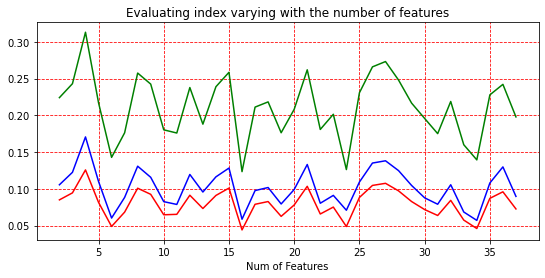

step = 0, the rmse, mae and mape are 0.06, 0.04, 0.12 respectively:


In [15]:
rmselist = []
maelist = []
mapelist = []
size = int(len(values) * (2 / 3))
# exclude t-0
for num_of_feature in range(2, len(df_all_shifted_series.columns)):
    rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_of_feature)
    # feature selection is part of training(learing), no data from test set should be used
    fit = rfe.fit(train_x, train_y)
    feature_choose_list = fit.support_
    ixList = []
    chosen_train_x = []
    chosen_test_x = []
    for i in range(len(feature_choose_list)):
        #print(feature_choose_list[i])
        # numpy._bool == True but not "is True"
        if feature_choose_list[i] == True:
            #print(f"{i} is chosen")
            ixList.append(i)
            chosen_train_x.append(train_x[:, i])
            chosen_test_x.append(test_x[:, i])

    chosen_train_x = np.array(chosen_train_x).T
    chosen_test_x = np.array(chosen_test_x).T

    y_pred = []
    model=get_model()
    model.fit(chosen_train_x, train_y)
    y_pred = model.predict(chosen_test_x)
    rmse = RMSE(list(test_y), y_pred)
    rmselist.append(rmse)
    mae = MAE(list(test_y), y_pred)
    maelist.append(mae)
    mape = MAPE(list(test_y), y_pred)
    mapelist.append(mape)
    print(
        f'num of feature is {num_of_feature}, rmse={rmse}, mae={mae}, mape={mape}'
    )

#plot
plt.figure(figsize=(9, 4))
plt.grid(c='r', ls='--')
plt.plot(range(2, len(rmselist) + 2), rmselist, 'b', label='rmse')
plt.plot(range(2, len(maelist) + 2), maelist, 'r', label='mae')
plt.plot(range(2, len(mapelist) + 2), mapelist, 'g', label='mape')
plt.title('Evaluating index varying with the number of features')
plt.xlabel('Num of Features')
plt.show()

rmselist = np.array(rmselist)
maelist = np.array(maelist)
mapelist = np.array(mapelist)
newlist = (rmselist + maelist + mapelist) / 3
newlist = list(newlist)
index = newlist.index(min(newlist))
# statring from 2 above, +2 back to count
optimal_feature_num = index + 2

print(
    'step = 0, the rmse, mae and mape are %.2f, %.2f, %.2f respectively:' %
    (rmselist[index], maelist[index], mapelist[index]))

In [16]:

rfe = RFE(DecisionTreeRegressor(),
            n_features_to_select=optimal_feature_num)
fit = rfe.fit(train_x, train_y)
feature_choose_list = fit.support_

chosen_train_x = []
chosen_test_x = []
chosen_values = []
for i in range(len(feature_choose_list)):
    #print(feature_choose_list[i])
    # numpy._bool
    if feature_choose_list[i] == True:  
        print(f"{i} is chosen")
        ixList.append(i)
        chosen_train_x.append(train_x[:, i])
        # chosen_test_x.append(test_x[:, i])
        chosen_values.append(values[:, i])
chosen_train_x = np.array(chosen_train_x).T
# chosen_test_x = np.array(chosen_test_x).T
chosen_values = np.array(chosen_values).T    



2 is chosen
4 is chosen
7 is chosen
12 is chosen
13 is chosen
14 is chosen
17 is chosen
19 is chosen
23 is chosen
24 is chosen
26 is chosen
28 is chosen
33 is chosen
34 is chosen
35 is chosen
36 is chosen


In [17]:

model=get_model()
model.fit(chosen_train_x,train_y)

y_pred_h1 = []
step = 1
for j in tqdm(range(size, len(values))):
    y_pred_h1.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])

rmse_h1 = RMSE(list(test_y), y_pred_h1)
mae_h1 = MAE(list(test_y), y_pred_h1)
mape_h1 = MAPE(list(test_y), y_pred_h1)


100%|██████████| 662/662 [00:02<00:00, 290.93it/s]


In [18]:

y_pred_h2 = []
step = 2
for j in tqdm(range(size, len(values))):
    y_pred_h2.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])

rmse_h2 = RMSE(list(test_y), y_pred_h2)
mae_h2 = MAE(list(test_y), y_pred_h2)
mape_h2 = MAPE(list(test_y), y_pred_h2)


100%|██████████| 662/662 [00:03<00:00, 186.00it/s]


In [19]:

y_pred_h3 = []
step = 3
for j in tqdm(range(size, len(values))):
    y_pred_h3.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])
rmse_h3 = RMSE(list(test_y), y_pred_h3)
mae_h3 = MAE(list(test_y), y_pred_h3)
mape_h3 = MAPE(list(test_y), y_pred_h3)

print(f"rmse_h1={rmse_h1}\n mae_h1 ={mae_h1}\n mape_h1 ={mape_h1}\n")
print(f"rmse_h2={rmse_h2}\n mae_h2 ={mae_h2}\n mape_h2 ={mape_h2}\n")
print(f"rmse_h3={rmse_h3}\n mae_h3 ={mae_h3}\n mape_h3 ={mape_h3}\n")




100%|██████████| 662/662 [00:02<00:00, 313.71it/s]

rmse_h1=0.10451267624470087
 mae_h1 =0.07823186243009327
 mape_h1 =0.20262796652254977

rmse_h2=0.10554649891323444
 mae_h2 =0.0791979883595665
 mape_h2 =0.2050779275027937

rmse_h3=0.10666296070029802
 mae_h3 =0.08019521176322718
 mape_h3 =0.2076148489132949



In [51]:
import datetime
timestamp_str=datetime.datetime.now().strftime("%d-%m-%YT%H:%M:%S")
with open("result.log","a+") as f:
    f.write(f"{timestamp_str}\n")
    f.write(f"optimal_feature_num: {optimal_feature_num}\n")
    f.write(f"chosen_features: {str(df_all_shifted_series.columns[ixList[-optimal_feature_num:]].tolist())}\n")
    f.write(f"rmse_h1= {rmse_h1}\nmae_h1 = {mae_h1}\nmape_h1 = {mape_h1}\n")
    f.write(f"rmse_h2= {rmse_h2}\nmae_h2 = {mae_h2}\nmape_h2 = {mape_h2}\n")
    f.write(f"rmse_h3= {rmse_h3}\nmae_h3 = {mae_h3}\nmape_h3 = {mape_h3}\n\n")

In [ ]:
df_h1=pd.DataFrame(y_pred_h1,index=range(size+7,len(values)+7),columns=["h1"])
df_h2=pd.DataFrame(y_pred_h2,index=range(size+7,len(values)+7),columns=["h2"])
df_h3=pd.DataFrame(y_pred_h3,index=range(size+7,len(values)+7),columns=["h3"])

In [22]:
df_normalized_price_n_pred=pd.concat([df_integrated_series[["date","normalized_price"]],df_h1,df_h2,df_h3],axis=1)

In [24]:
#df_normalized_price_n_pred.to_csv("normalized_price_n_pred(3-1).csv",index=False)

<AxesSubplot:xlabel='date'>

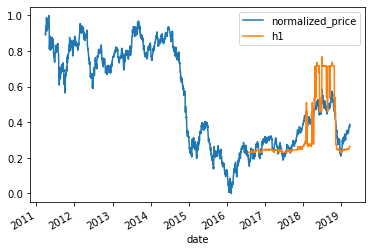

In [25]:
#df_normalized_price_n_pred.set_index("date")[["normalized_price","h1"]].plot()

<AxesSubplot:xlabel='date'>

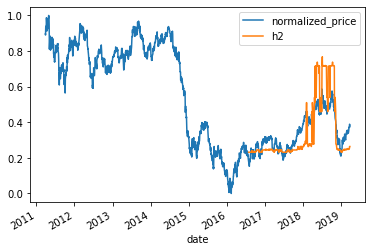

In [26]:
#df_normalized_price_n_pred.set_index("date")[["normalized_price","h2"]].plot()

<AxesSubplot:xlabel='date'>

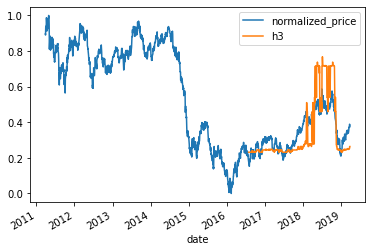

In [27]:
#df_normalized_price_n_pred.set_index("date")[["normalized_price","h3"]].plot()